<a href="https://colab.research.google.com/github/Mdipietro1990/masters-program/blob/CNN_models_HW/Homework_Final_Dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import keras
from keras.applications import VGG16
import os
import numpy as np
import pandas as pd
import glob
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Input
from keras import regularizers, optimizers, layers, models
from IPython.display import Image

In [0]:
if not os.path.exists('/content/train') or os.path.exists('/content/test'):
  !unzip -q '/content/drive/My Drive/Colab Notebooks/dog-breed-identification/train.zip'
  !unzip -q '/content/drive/My Drive/Colab Notebooks/dog-breed-identification/test.zip'
else:
  print('Already unzipped')

In [0]:
def append_ext(fn):
    return fn+".jpg"


In [0]:
labels_breed = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dog-breed-identification/labels.csv")
labels_breed['id'] = append_ext(labels_breed['id'])

In [16]:
labels_breed.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [17]:
BATCH = 32
imagegen = ImageDataGenerator(rescale=1./255,
                              zoom_range=.1,
                              width_shift_range=.1,
                              height_shift_range=.1,
                              rotation_range=30,
                              horizontal_flip=True,
                              validation_split=.2
                              )

train_generator = imagegen.flow_from_dataframe(dataframe=labels_breed,
                                                directory='/content/train',
                                                x_col='id',
                                                y_col='breed',
                                                class_mode='categorical',
                                                target_size=(224,224),
                                                subset='training',
                                                batch_size=BATCH)

val_generator = imagegen.flow_from_dataframe(dataframe=labels_breed,
                                            directory='/content/train',
                                            x_col='id',
                                            y_col='breed',
                                            class_mode='categorical',
                                            target_size=(224,224),
                                            subset='validation',
                                            batch_size=BATCH)


# test_generator = imagegen.flow_from_dataframe(dataframe=labels_breed,
#                                              directory='/content/test',
#                                              target_size=(224, 224),
#                                              batch_size=BATCH,
#                                              class_mode='binary')

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [18]:
val_generator.image_shape

(224, 224, 3)

In [0]:
keras.backend.clear_session()
resnet = keras.applications.ResNet50V2(include_top=False, 
                                       weights='imagenet', 
                                       input_shape=(224,224,3))
resnet.trainable=False

model = keras.Sequential([resnet, 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(120, activation='softmax')])

model.compile(
    optimizer=Adam(lr=0.001), 
    loss=keras.losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
model.layers[0].summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [22]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=val_generator,
      validation_steps=len(val_generator))

Epoch 1/30
100/100 [==============================] - 83s 830ms/step - loss: 3.6748 - acc: 0.2103 - val_loss: 2.2049 - val_acc: 0.4266
Epoch 2/30
100/100 [==============================] - 72s 725ms/step - loss: 2.3801 - acc: 0.4139 - val_loss: 1.8010 - val_acc: 0.5352
Epoch 3/30
100/100 [==============================] - 73s 731ms/step - loss: 1.9370 - acc: 0.5109 - val_loss: 1.8230 - val_acc: 0.5504
Epoch 4/30
100/100 [==============================] - 73s 730ms/step - loss: 1.6732 - acc: 0.5628 - val_loss: 1.7700 - val_acc: 0.5807
Epoch 5/30
100/100 [==============================] - 73s 730ms/step - loss: 1.6034 - acc: 0.5714 - val_loss: 1.7686 - val_acc: 0.5944
Epoch 6/30
100/100 [==============================] - 73s 729ms/step - loss: 1.3727 - acc: 0.6311 - val_loss: 1.8028 - val_acc: 0.5778
Epoch 7/30
100/100 [==============================] - 74s 739ms/step - loss: 1.3590 - acc: 0.6316 - val_loss: 1.8082 - val_acc: 0.5934
Epoch 8/30
100/100 [==============================] - 7

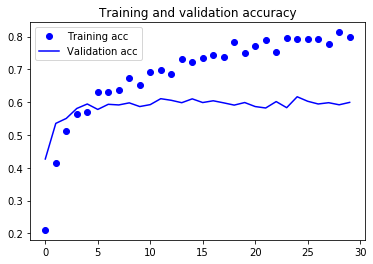

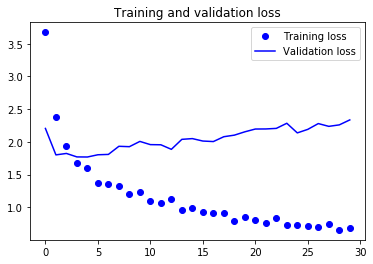

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

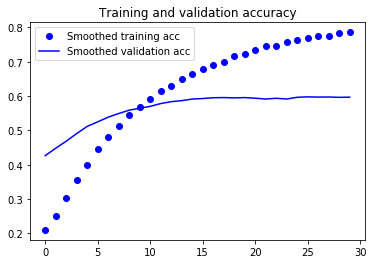

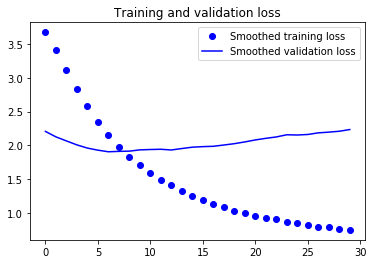

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Visualization

In [25]:
from keras.preprocessing import image
import numpy as np
#img_path = '/content/train/01de1f7b7b4465a6d130a56746af66a6.jpg'
img_path = '/content/train/75fe24028284a2ba927e6fd111510aa3.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 224, 224, 3)


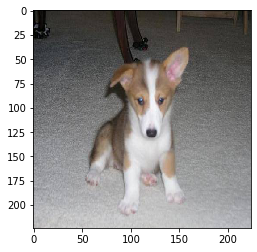

In [26]:
plt.imshow(img_tensor[0])
plt.show()

In [0]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[0].layers[1:12]]
# Creates a model that will return these outputs, given the model input:
activation_model = keras.models.Model(inputs=resnet.inputs, outputs=layer_outputs)

In [0]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [29]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 112, 112, 64)


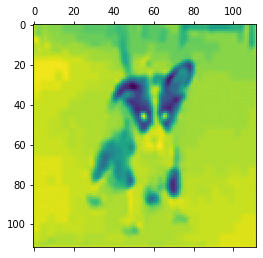

In [30]:
plt.matshow(first_layer_activation[0, :, :, 2])

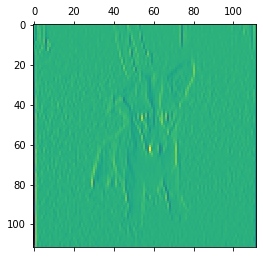

In [31]:
plt.matshow(first_layer_activation[0, :, :, 23], cmap='viridis')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


RuntimeError: ignored

<Figure size 1152x0 with 1 Axes>

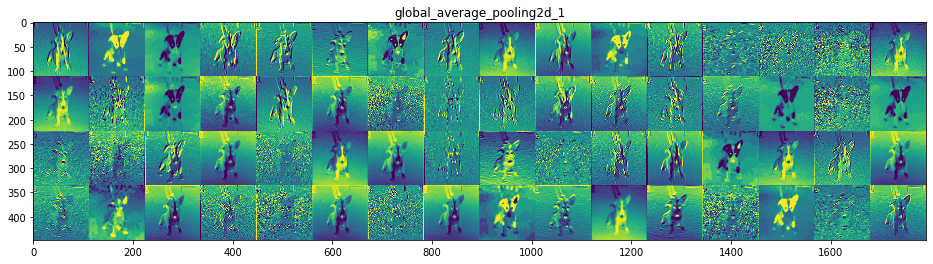

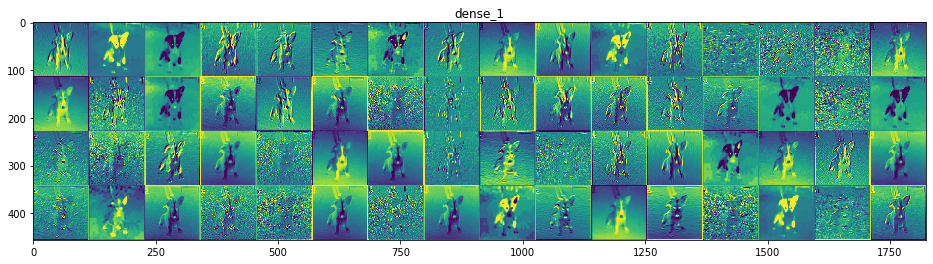

In [32]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [33]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

58892288/58889256 [==============================] - 6s 0us/step


In [34]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]
print(grads)


Tensor("gradients/block1_conv1/convolution_grad/Conv2DBackpropInput:0", shape=(?, ?, ?, 3), dtype=float32)


In [0]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

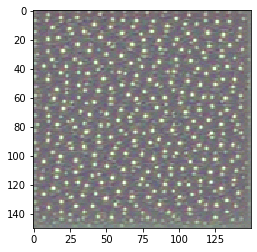

In [40]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

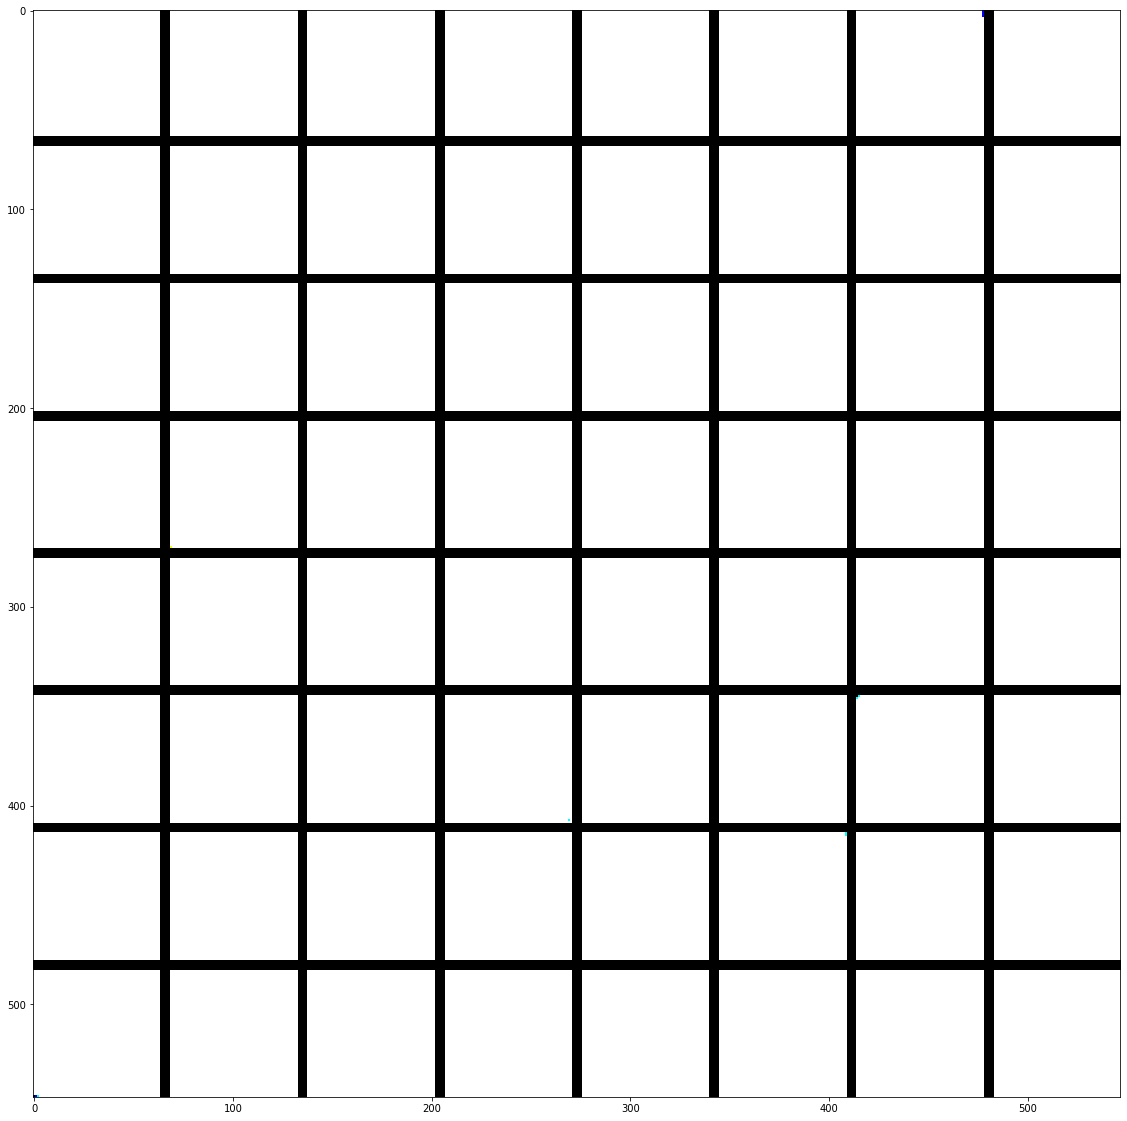

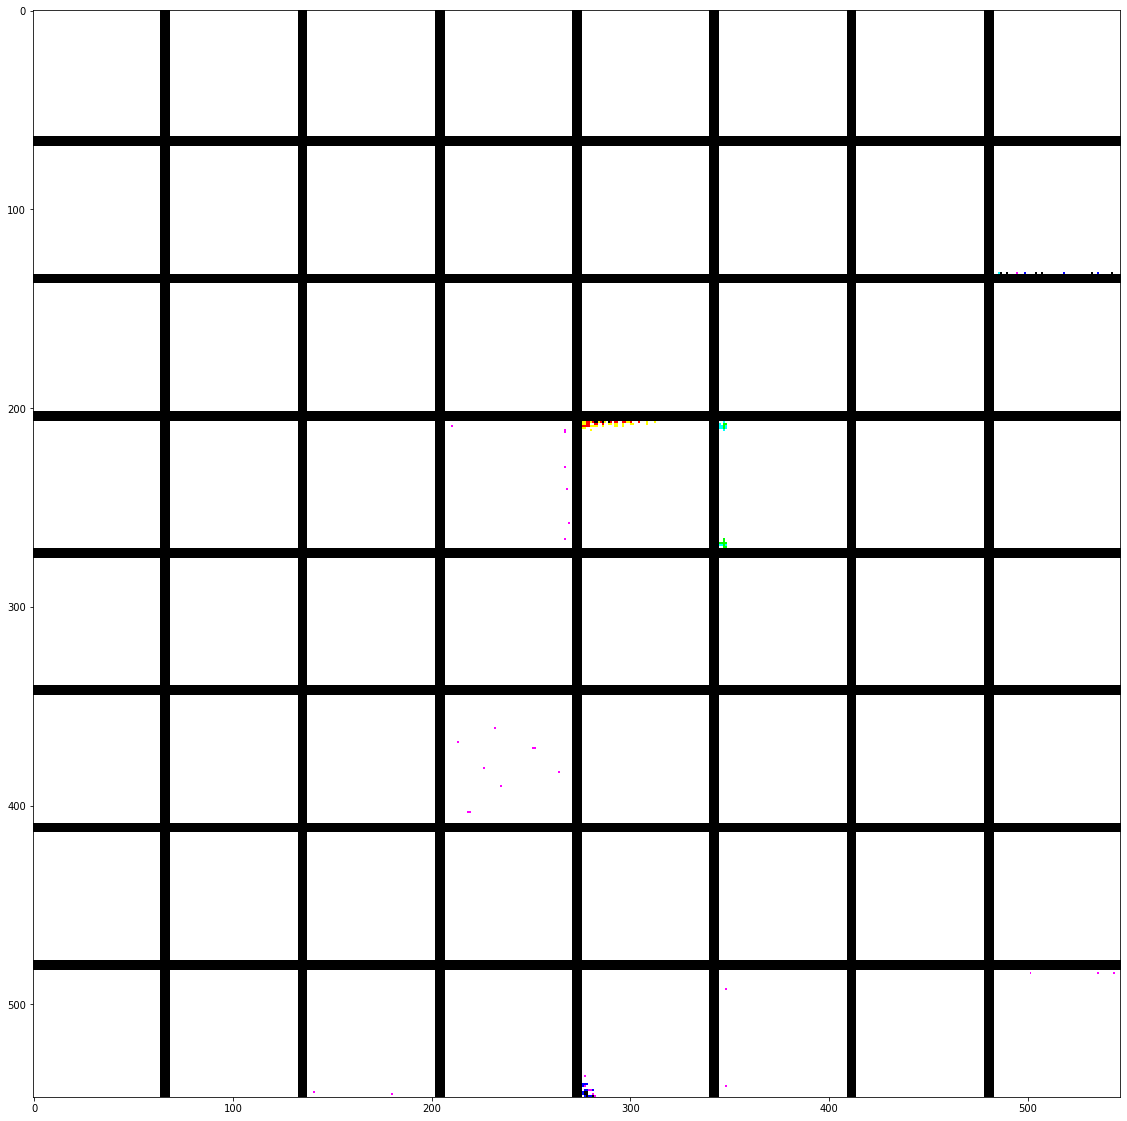

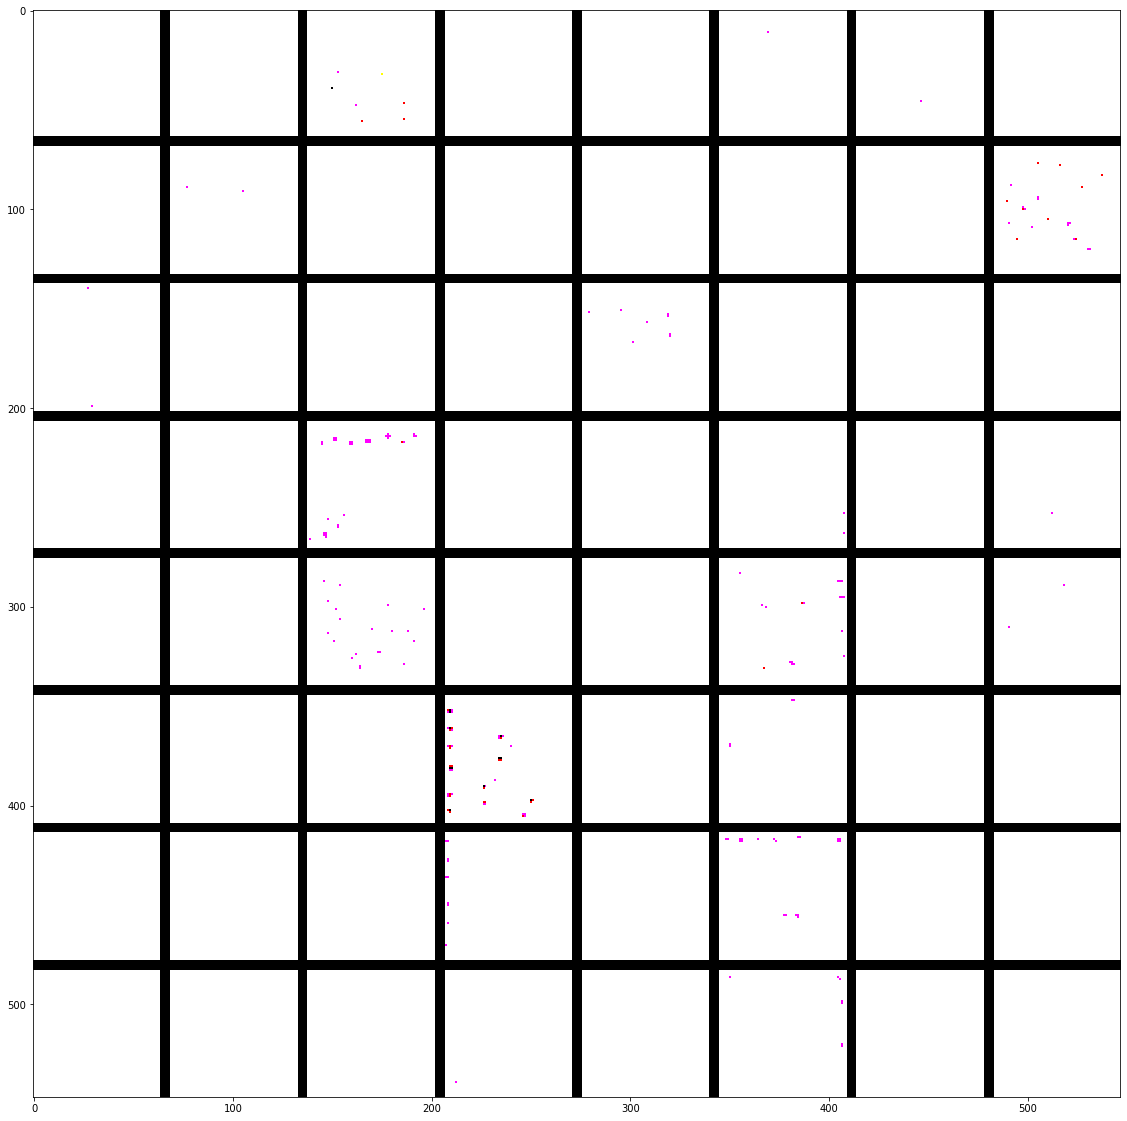

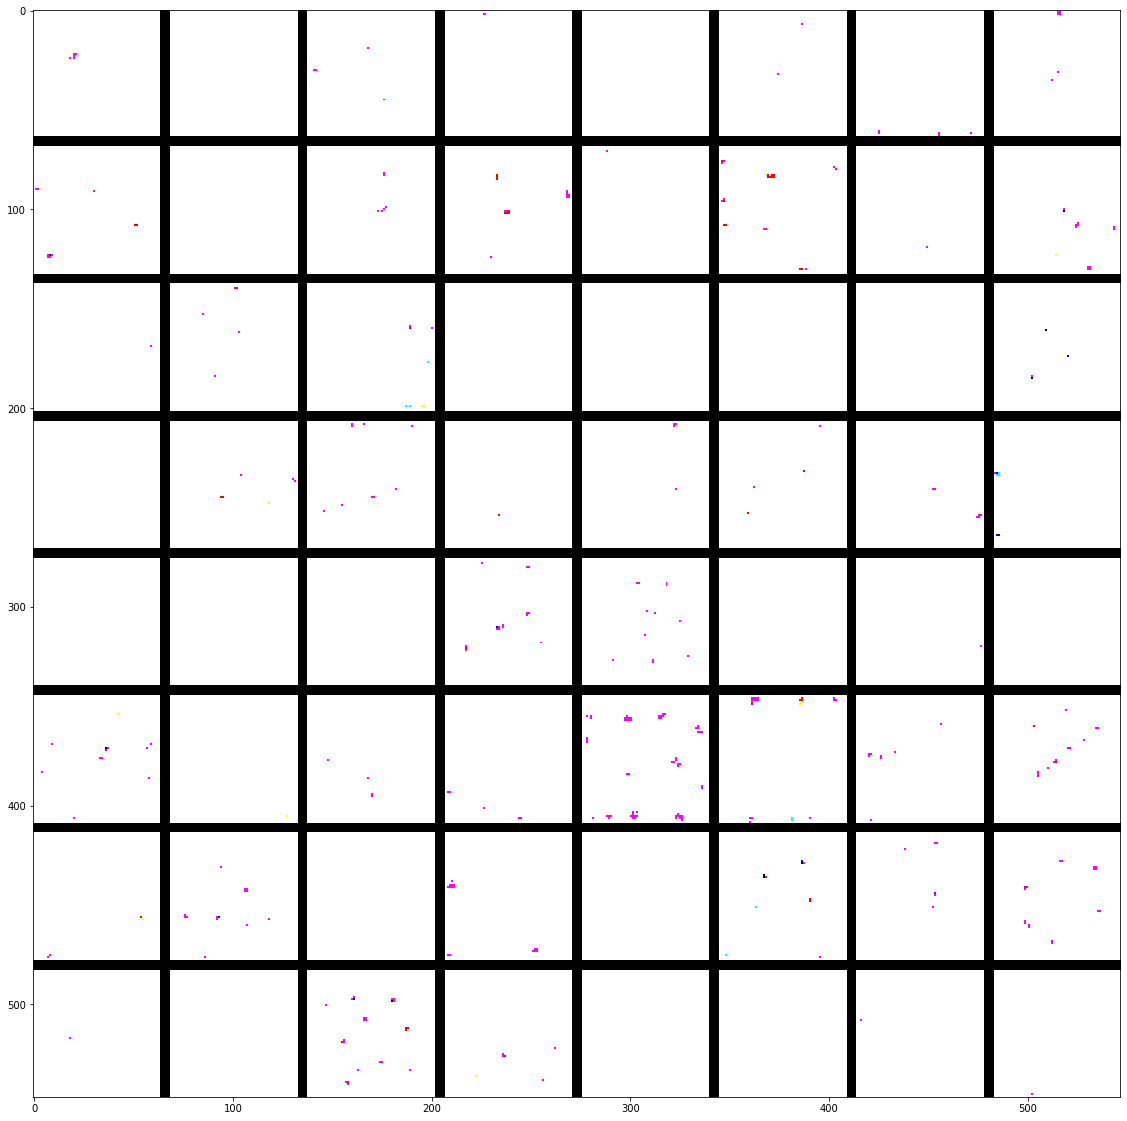

In [41]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [42]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 37s 0us/step


In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [44]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5))

40960/35363 [==================================] - 0s 0us/step
Predicted: [[('n02113023', 'Pembroke', 0.7727261), ('n02113186', 'Cardigan', 0.07438526), ('n02110806', 'basenji', 0.07115696), ('n02105855', 'Shetland_sheepdog', 0.051685605), ('n02087046', 'toy_terrier', 0.0073812837)]]


In [45]:
np.argmax(preds[0])

263

In [46]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 157]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

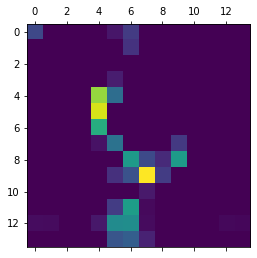

In [48]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()


In [59]:
import cv2
from google.colab.patches import cv2_imshow

if not os.path.exists('/content/pics/'):
  os.system('mkdir /content/pics')

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('/content/pics/dog_heatmap.jpg', superimposed_img)


True

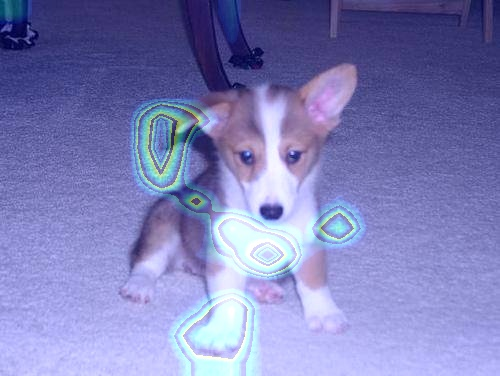

In [60]:
Image('/content/pics/dog_heatmap.jpg', width=250, height=400)